In [15]:
import os
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot  as plt
from tqdm import tqdm

In [4]:
def load_images_from_folder(folder_label_pairs, image_size=None):
    data = []

    for folder, label in folder_label_pairs:
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path).convert('RGB')

                if image_size:
                    img = img.resize(image_size)

                img_array = np.array(img).flatten()
                data.append({
                    'flattened_pixels': img_array,
                    'label': label
                })

    df = pd.DataFrame(data)
    return df

In [5]:
class0_folder = r"E:\Jain Irrigation\data\A\train_cropped"
class1_folder = r"E:\Jain Irrigation\data\D\train_cropped"

In [6]:
folders = [
    (class0_folder, 1),
    (class1_folder, 0)
]

In [1]:
widths, heights = [], []

for folder in folders:
    print(f"\nChecking folder: {folder}")
    for filename in tqdm(os.listdir(folder)):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        path = os.path.join(folder, filename)
        try:
            with Image.open(path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            print(f"⚠️ Skipped {filename}: {e}")

widths, heights = np.array(widths), np.array(heights)

print("\n===== IMAGE SIZE SUMMARY =====")
print(f"Total images: {len(widths)}")
print(f"Width  → min: {widths.min()}, max: {widths.max()}, mean: {widths.mean():.1f}")
print(f"Height → min: {heights.min()}, max: {heights.max()}, mean: {heights.mean():.1f}")

NameError: name 'folders' is not defined

In [ ]:
def load_images_with_padding(folder_label_pairs, image_size=(128,128), pad_color=(255,255,255)):
    data = []

    for folder, label in folder_label_pairs:
        image_files = [f for f in os.listdir(folder)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for filename in tqdm(image_files, desc=f"Processing {os.path.basename(folder)}"):
            path = os.path.join(folder, filename)
            try:
                img = Image.open(path).convert("RGB")

                # Preserve aspect ratio
                img.thumbnail(image_size, Image.Resampling.LANCZOS)

                # Create white background
                background = Image.new("RGB", image_size, pad_color)
                offset = (
                    (image_size[0] - img.width) // 2,
                    (image_size[1] - img.height) // 2
                )
                background.paste(img, offset)

                img_array = np.array(background) / 255.0   # normalize
                flat = img_array.flatten()

                data.append({
                    'flattened_pixels': flat,
                    'label': label
                })
            except Exception as e:
                print(f"⚠️ Skipped {filename}: {e}")

    df = pd.DataFrame(data)
    return df

                                    flattened_pixels  label
0  [124, 129, 124, 114, 118, 113, 103, 109, 101, ...      1
1  [117, 110, 104, 196, 191, 186, 235, 237, 233, ...      1
2  [166, 163, 158, 166, 163, 158, 164, 161, 156, ...      1
3  [164, 160, 152, 165, 160, 154, 167, 162, 156, ...      1
4  [161, 166, 168, 171, 173, 172, 156, 160, 157, ...      1
(164, 2)


In [8]:
X = np.stack(df['flattened_pixels'].values)
y = df['label'].values

# normalize pixel values
X = X / 255.0

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.9090909090909091


In [19]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# Standard training/testing split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# --- 1. Overall accuracy ---
acc = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", round(acc, 3))

# --- 2. Classification report ---
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

✅ Accuracy: 0.909

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.89      0.94      0.91        17

    accuracy                           0.91        33
   macro avg       0.91      0.91      0.91        33
weighted avg       0.91      0.91      0.91        33



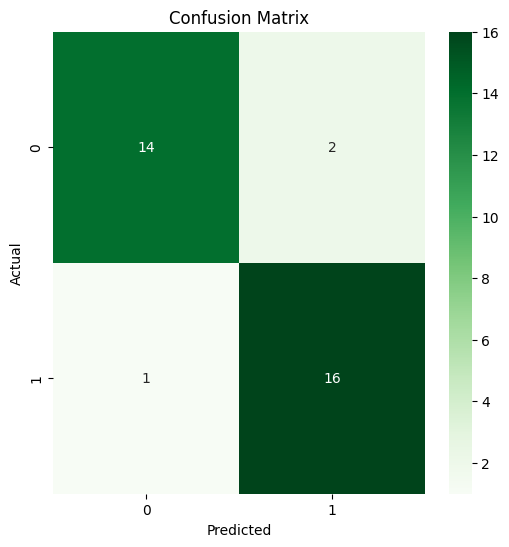

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(np.unique(y))  # class names or numeric labels

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

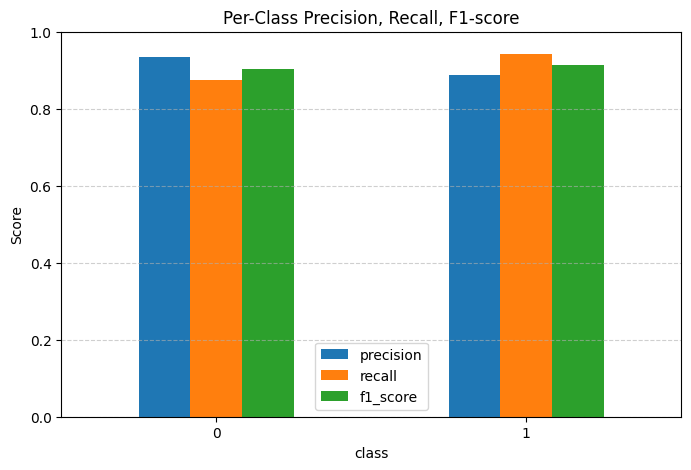

In [21]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
metrics_df = pd.DataFrame({
    "class": labels,
    "precision": prec,
    "recall": rec,
    "f1_score": f1
})

metrics_df.plot(x="class", kind="bar", figsize=(8,5))
plt.title("Per-Class Precision, Recall, F1-score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
def predict_flattened_images(model, folder_label_pairs, image_size=(128,128)):
    results = []

    for folder, _ in folder_label_pairs:
        print("\n=== Processing folder:", folder, "===")
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        print(f"Total image files detected: {len(files)}")
        
        for filename in tqdm(files, desc=f"Predicting in {os.path.basename(folder)}"):
            path = os.path.join(folder, filename)
            try:
                img = Image.open(path).convert("RGB").resize(image_size)
                flat = (np.array(img) / 255.0).flatten().reshape(1, -1)
                pred = model.predict(flat)[0]
                conf = np.max(model.predict_proba(flat))
                results.append({
                    "folder": folder,
                    "image": filename,
                    "predicted_label": pred,
                    "confidence": round(conf, 3)
                })
            except Exception as e:
                print(f"⚠️ Skipped {filename}: {e}")

    return pd.DataFrame(results)


In [ ]:
folders_test_a = [(r"E:\Jain Irrigation\data\A\test_cropped", None)]
pred_df_a = predict_flattened_images(model, folders_test_a)
pred_df_a["Actual"] = [1]*len(pred_df_a)  # Assuming all test images are class 1
print(pred_df_a)

Predicting in test_cropped: 100%|██████████| 20/20 [00:00<00:00, 157.07it/s]

                             image  predicted_label  confidence  Actual
0       IMG_20250920_114308655.jpg                0       1.000       1
1       IMG_20250920_114321040.jpg                0       1.000       1
2       IMG_20250920_114337247.jpg                0       1.000       1
3       IMG_20250920_114349302.jpg                0       0.999       1
4   IMG_20250920_114411742_HDR.jpg                0       1.000       1
5       IMG_20250920_114424698.jpg                0       1.000       1
6       IMG_20250920_114459816.jpg                0       0.999       1
7       IMG_20250920_114510244.jpg                0       1.000       1
8       IMG_20250920_114546151.jpg                0       0.999       1
9   IMG_20250920_114557923_HDR.jpg                0       1.000       1
10      IMG_20250920_114634292.jpg                0       1.000       1
11      IMG_20250920_114642676.jpg                0       1.000       1
12  IMG_20250920_114726232_HDR.jpg                0       1.000 

In [ ]:
folders_test_d = [(r"E:\Jain Irrigation\data\D\test_cropped", None)]
pred_df_d = predict_flattened_images(model, folders_test_d)
pred_df_d["Actual"] = [1]*len(pred_df_d)  # Assuming all test images are class 1
print(pred_df_d)

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
from sklearn.metrics import accuracy_score

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# continuous predictions
y_pred_cont = linear_model.predict(X_test)

# threshold to classify
y_pred_lin = (y_pred_cont >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_lin))

Accuracy: 0.9090909090909091


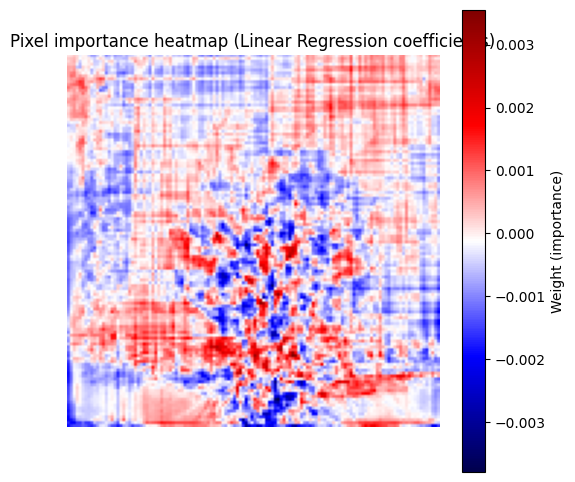

In [12]:
height, width = 128, 128
num_channels = 3  # RGB

# model.coef_ is a 1D array of weights for each pixel (flattened)
coeffs = linear_model.coef_

# Reshape back to image dimensions
coeffs_image = coeffs.reshape(height, width, num_channels)

# Take mean across color channels for visualization
coeffs_gray = np.mean(coeffs_image, axis=2)

plt.figure(figsize=(6,6))
plt.imshow(coeffs_gray, cmap='seismic')
plt.colorbar(label="Weight (importance)")
plt.title("Pixel importance heatmap (Linear Regression coefficients)")
plt.axis("off")
plt.show()